In [136]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, LSTM
from keras.optimizers import RMSprop
from keras.layers import SimpleRNN


import math
import pandas as pd

import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt


In [266]:
file_path = "dataA.csv"

In [267]:
# read csv file from data.csv file
nepse_df = pd.read_csv(file_path, header = 0)

In [268]:
# Check the data in the top of the dataframe
nepse_df.head()

(5399, 8)

In [269]:
# Check of null or missing data
nepse_df.isnull().sum()

Symbol            0
Date              0
Open              0
High              0
Low               0
Close             0
percent_change    0
Volume            0
dtype: int64

In [270]:
# Filter data based on choice
class CustomError(Exception):
  pass

scrip_list = list(nepse_df['Symbol'].unique())
print("Available Scrip are", scrip_list)
SCRIP = input("Enter the Scrip you want to analyze: ")

if SCRIP in scrip_list:
  nepse_df = nepse_df[nepse_df['Symbol'] == SCRIP]
else:
  print("Scrip is not valid")
  raise CustomError("Wrong Input")

Available Scrip are ['LBBL', 'NABIL', 'NBL', 'NHPC', 'SICL']


In [271]:
# Perform 80 - 20 split for training and test data
values = nepse_df['Close'].values
training_data_len = math.ceil(len(values)* 0.8)

In [272]:
df = nepse_df.copy()

# Add moving average
df['Moving_Avg'] = df['Close'].rolling(window=5).mean()

# Function to compute RSI
def compute_rsi(data, window):
    diff = data.diff()
    up_chg = 0 * diff
    down_chg = 0 * diff

    up_chg[diff > 0] = diff[ diff>0 ]
    down_chg[diff < 0] = diff[ diff < 0 ]

    up_chg_avg   = up_chg.rolling(window=window).mean()
    down_chg_avg = down_chg.rolling(window=window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

# Add RSI
df['RSI'] = compute_rsi(df['Close'], 5)
df = df.dropna()  # Drop NaN values
df.head()

,Symbol,Date,Open,High,Low,Close,percent_change,Volume,Moving_Avg,RSI
5,LBBL,07/08/2022,349.2,349.2,330.0,330.1,-4.60,36211,328.40,38.477801
6,LBBL,07/07/2022,360.0,368.0,343.0,346.0,-2.54,37061,328.80,51.661130
7,LBBL,07/06/2022,349.0,358.0,335.0,355.0,0.85,62733,332.20,63.449367
8,LBBL,07/05/2022,353.0,370.0,345.0,352.0,-2.22,60796,339.60,92.824074
9,LBBL,07/04/2022,370.0,382.0,350.0,360.0,-1.37,108253,348.62,94.129159


In [273]:
# Features and target variable
features = df[['Open', 'Moving_Avg', 'RSI']]
target = df['Close']

# Split data into 80-20 for training and testing
training_data_len = int(0.8 * len(features))
train_features = features[:training_data_len]
train_target = target[:training_data_len]
test_features = features[training_data_len:]
test_target = target[training_data_len:]

# Scale the features
scaler_features = StandardScaler()
train_features_scaled = scaler_features.fit_transform(train_features)
test_features_scaled = scaler_features.transform(test_features)

# Scale the target
scaler_target = StandardScaler()
train_target_scaled = scaler_target.fit_transform(train_target.values.reshape(-1, 1))
test_target_scaled = scaler_target.transform(test_target.values.reshape(-1, 1))

# Create data structure with 5 timestamps for training and testing data
window_size = 5
x_train, y_train, x_test, y_test = [], [], [], []

for i in range(window_size, len(train_features_scaled)):
    x_train.append(train_features_scaled[i-window_size:i])
    y_train.append(train_target_scaled[i])
for i in range(window_size, len(test_features_scaled)):
    x_test.append(test_features_scaled[i-window_size:i])
    y_test.append(test_target_scaled[i])

x_train, y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)


## Build a Model



### 1. RNN Model

In [275]:
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(x_train.shape[1], 3)))
model.add(Dropout(0.2, name = 'd1'))
model.add(SimpleRNN(units=75, return_sequences=False))
model.add(Dropout(0.2, name = 'd2'))
model.add(Dense(units=20))
model.add(Dense(units=1))
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mean_squared_error')


In [276]:
rnn_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_16 (SimpleRNN)   (None, 50)                2700      
                                                                 
 dropout_30 (Dropout)        (None, 50)                0         
                                                                 
 dense_30 (Dense)            (None, 1)                 51        
                                                                 
Total params: 2,751
Trainable params: 2,751
Non-trainable params: 0
_________________________________________________________________


In [277]:
model.fit(x_train, y_train, epochs=epochs, validation_split=0.2)

Epoch 1/50
23/23 [==============================] - 5s 55ms/step - loss: 0.4060 - val_loss: 0.0608
Epoch 2/50
23/23 [==============================] - 0s 10ms/step - loss: 0.1726 - val_loss: 0.0515
Epoch 3/50
23/23 [==============================] - 0s 10ms/step - loss: 0.1190 - val_loss: 0.0182
Epoch 4/50
23/23 [==============================] - 0s 10ms/step - loss: 0.0950 - val_loss: 0.0137
Epoch 5/50
23/23 [==============================] - 0s 10ms/step - loss: 0.0749 - val_loss: 0.0199
Epoch 6/50
23/23 [==============================] - 0s 14ms/step - loss: 0.0539 - val_loss: 0.0413
Epoch 7/50
23/23 [==============================] - 0s 10ms/step - loss: 0.0556 - val_loss: 0.0071
Epoch 8/50
23/23 [==============================] - 0s 11ms/step - loss: 0.0459 - val_loss: 0.0288
Epoch 9/50
23/23 [==============================] - 0s 10ms/step - loss: 0.0486 - val_loss: 0.0157
Epoch 10/50
23/23 [==============================] - 0s 11ms/step - loss: 0.0432 - val_loss: 0.0403
Epoch 11/

In [278]:
model.save_weights(f"models/{SCRIP}_RNN.h5")

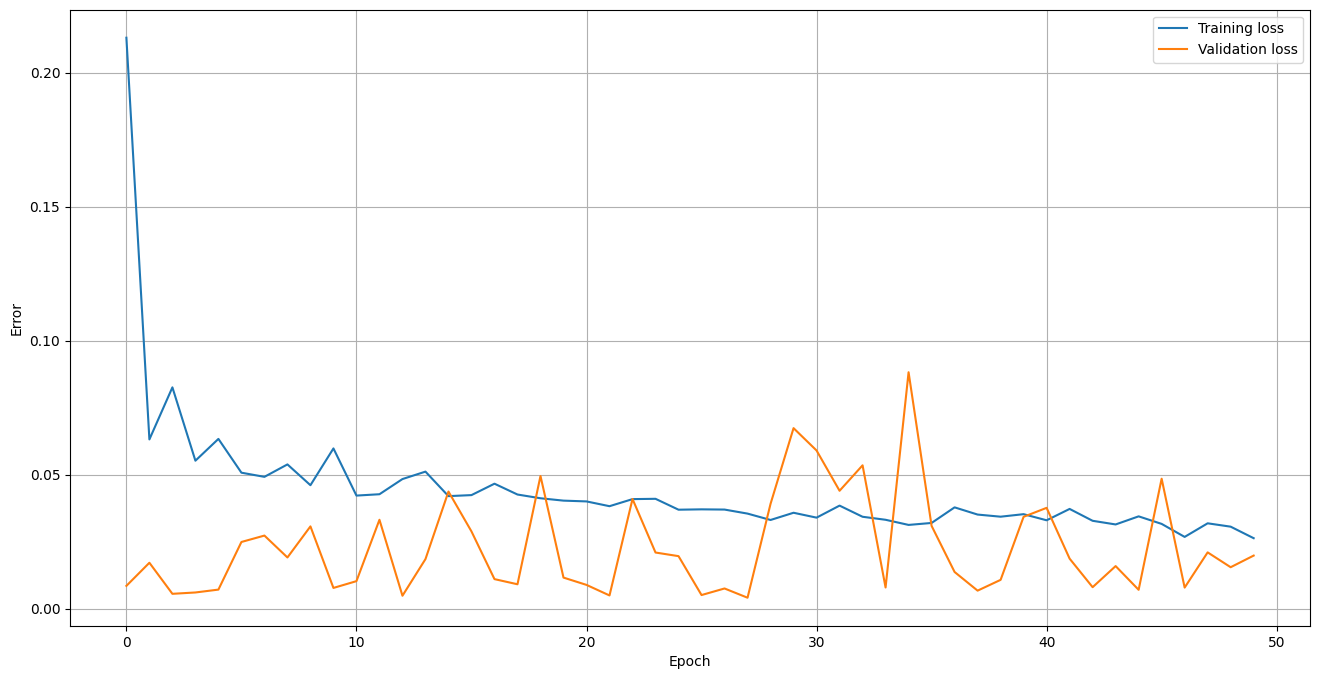

In [279]:
def plot_loss(history):
  plt.figure(figsize=(16,8))
  plt.plot(history.history['loss'], label='Training loss')
  plt.plot(history.history['val_loss'], label='Validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [254]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rnn_rmse = np.sqrt(np.mean(predictions - y_test)**2)
rnn_rmse

8/8 [==============================] - 1s 3ms/step


2164.524553174645

In [255]:
# data = nepse_df.filter(['Close'])
# train = data[:training_data_len]
# validation = data[training_data_len:]
# validation['Predictions'] = predictions
# plt.figure(figsize=(16,8))
# plt.title('Training on RNN Model')
# plt.xlabel('Date')
# plt.ylabel('Closing Price')
# plt.plot(train)
# plt.plot(validation[['Close', 'Predictions']])
# plt.legend(['Training', 'Validations', 'Predictions'], loc='upper right')
# plt.show()

### 2. LSTM Model

In [256]:
# Define the RNN Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape= (x_train.shape[1], 3)))
model.add(Dropout(0.2))
model.add(LSTM(units=75, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=20))
model.add(Dense(units=1))
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mean_squared_error')
model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 5, 50)             10800     
                                                                 
 dropout_61 (Dropout)        (None, 5, 50)             0         
                                                                 
 lstm_19 (LSTM)              (None, 5, 75)             37800     
                                                                 
 dropout_62 (Dropout)        (None, 5, 75)             0         
                                                                 
 lstm_20 (LSTM)              (None, 50)                25200     
                                                                 
 dropout_63 (Dropout)        (None, 50)                0         
                                                                 
 dense_57 (Dense)            (None, 20)              

In [257]:
epochs = 50
history = model.fit(x_train, y_train, epochs = epochs, validation_split=0.2)

Epoch 1/50
26/26 [==============================] - 15s 110ms/step - loss: 0.2130 - val_loss: 0.0085
Epoch 2/50
26/26 [==============================] - 1s 20ms/step - loss: 0.0632 - val_loss: 0.0171
Epoch 3/50
26/26 [==============================] - 1s 20ms/step - loss: 0.0826 - val_loss: 0.0056
Epoch 4/50
26/26 [==============================] - 1s 24ms/step - loss: 0.0552 - val_loss: 0.0061
Epoch 5/50
26/26 [==============================] - 1s 19ms/step - loss: 0.0634 - val_loss: 0.0071
Epoch 6/50
26/26 [==============================] - 0s 19ms/step - loss: 0.0508 - val_loss: 0.0249
Epoch 7/50
26/26 [==============================] - 0s 18ms/step - loss: 0.0492 - val_loss: 0.0273
Epoch 8/50
26/26 [==============================] - 0s 17ms/step - loss: 0.0538 - val_loss: 0.0191
Epoch 9/50
26/26 [==============================] - 1s 21ms/step - loss: 0.0461 - val_loss: 0.0307
Epoch 10/50
26/26 [==============================] - 1s 21ms/step - loss: 0.0598 - val_loss: 0.0078
Epoch 1

In [258]:
model.save_weights(f"models/{SCRIP}_LSTM.h5")

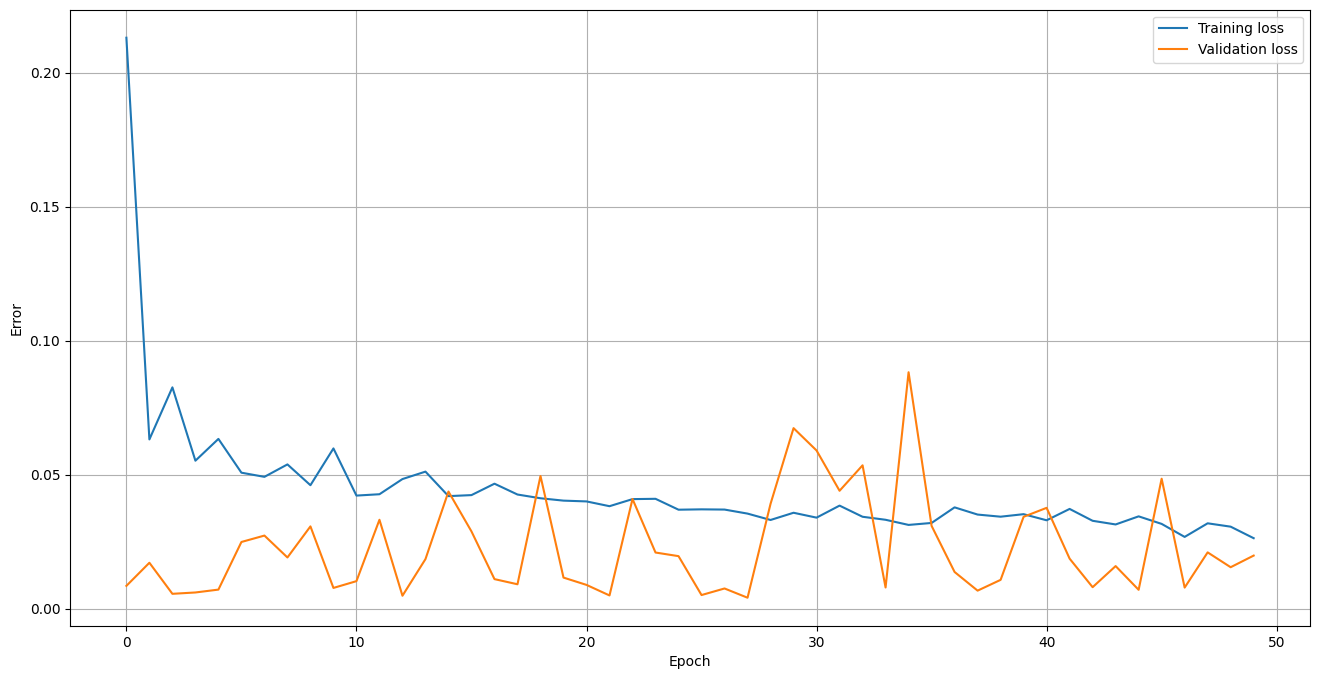

In [259]:
plot_loss(history)

In [260]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
lstm_rmse = np.sqrt(np.mean(predictions - y_test)**2)
lstm_rmse

8/8 [==============================] - 4s 6ms/step


1990.809328881565

In [261]:
# data = nepse_df.filter(['Close'])
# train = data[:training_data_len]
# validation = data[training_data_len:]
# validation['Predictions'] = predictions
# plt.figure(figsize=(16,8))
# plt.title('Model')
# plt.xlabel('Date')
# plt.ylabel('Closing Price')
# plt.plot(train)
# plt.plot(validation[['Close', 'Predictions']])
# plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
# plt.show()

In [262]:
# if rnn_rmse > lstm_rmse:
#   print("RNN works better than LSTM for", SCRIP)
# elif rnn_rmse < lstm_rmse:
#   print("LSTM works better than RMSE for", SCRIP)
# else:
#   print("The performance of RNN and LSTM are same.")

## Implementing feature engineering and GRU

In [263]:
# Define the GRU Model
gru_model = Sequential()
gru_model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], 3)))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(units=75, return_sequences=False))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(units=20))
gru_model.add(Dense(units=1))
gru_model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mean_squared_error')

# Train the model
gru_history = gru_model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/50
26/26 [==============================] - 15s 89ms/step - loss: 0.0939 - val_loss: 0.0333
Epoch 2/50
26/26 [==============================] - 1s 24ms/step - loss: 0.0407 - val_loss: 0.0036
Epoch 3/50
26/26 [==============================] - 0s 19ms/step - loss: 0.0424 - val_loss: 0.0038
Epoch 4/50
26/26 [==============================] - 0s 19ms/step - loss: 0.0380 - val_loss: 0.0047
Epoch 5/50
26/26 [==============================] - 1s 25ms/step - loss: 0.0343 - val_loss: 0.0056
Epoch 6/50
26/26 [==============================] - 1s 22ms/step - loss: 0.0323 - val_loss: 0.0150
Epoch 7/50
26/26 [==============================] - 0s 17ms/step - loss: 0.0297 - val_loss: 0.0685
Epoch 8/50
26/26 [==============================] - 1s 21ms/step - loss: 0.0325 - val_loss: 0.0059
Epoch 9/50
26/26 [==============================] - 0s 18ms/step - loss: 0.0302 - val_loss: 0.0031
Epoch 10/50
26/26 [==============================] - 0s 17ms/step - loss: 0.0322 - val_loss: 0.0079
Epoch 11

In [264]:
gru_model.save_weights(f"models/{SCRIP}_GRU.h5")

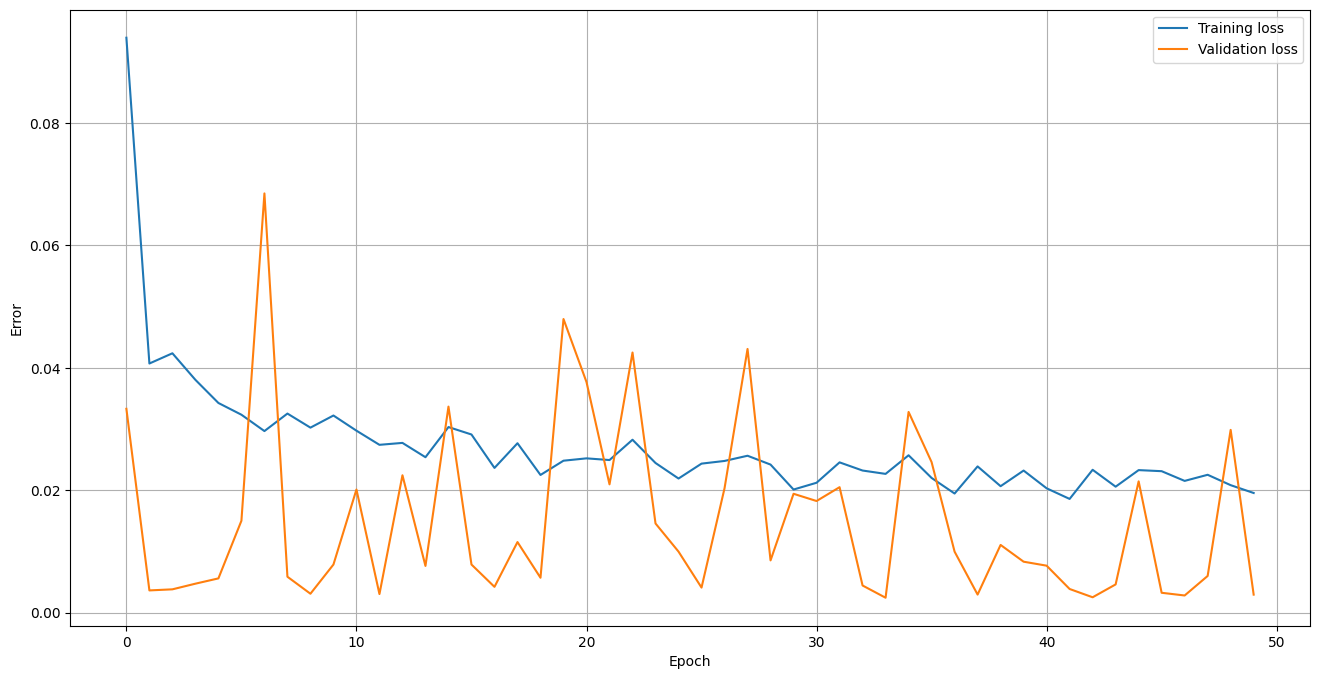

In [265]:
plot_loss(gru_history)